## Step 1: Run all once and proceed to step 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as sk
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.linear_model import Perceptron as pc
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Data 

In [2]:
drug_data = pd.read_csv('drug200.csv')

#The drug data from the CSV file in the form of a data frame

drug_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


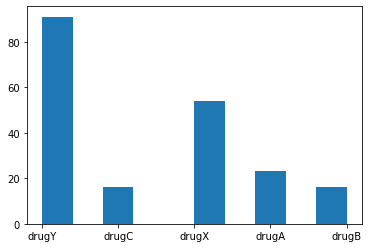

In [35]:
# Plot of the distribution of the classes within the data
x = plt.hist(drug_data.Drug)
plt.savefig('drug-distribution.pdf')

In [4]:
# Converting the features into numerical data
N_to_K = drug_data.Na_to_K
Age = drug_data.Age
Sex_nf = pd.get_dummies(drug_data.Sex)
BP_nf = pd.Categorical(drug_data.BP, ordered = True, categories = ['LOW', 'NORMAL', 'HIGH'])
Chol_nf = pd.Categorical(drug_data.Cholesterol, ordered = True, categories = ['NORMAL', 'HIGH'])
BP_nf = pd.DataFrame({'BP': BP_nf.codes})
Chol_nf = pd.DataFrame({'Cholesterol' :Chol_nf.codes})

# Concatenating the converted features and classes into seperate dataframes
drug_features = [Age, Sex_nf, BP_nf, Chol_nf, N_to_K]
drug_features = pd.concat(drug_features, axis=1, join = 'inner')
drug_target = drug_data.Drug


In [5]:
# Splitting the data with train_test_split with its default parameters
# and sets converts the splitted data into numpy arrays
x_train, x_test, y_train, y_test = sk.train_test_split(drug_features, drug_target)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Metrics

In [6]:
# Functions to get metrics
# Uses the metrics module provided from sklearn to gather all the required metrics from each model

# returns a dictionary with the keys and values being each metric and result respectively for the model 
# drug_classes are the classes of the data
# The index refers to the indeices of the data that has been split into their respective training or testing categories
# pred is the predicted ouputs generated by the model when fed data
# targets are the actual outputs coresponding to the predicted data
def getMetrics(drug_classes, index, pred, targets):
    class_recall = recall_score(targets, pred, average= None)
    class_precision = precision_score(targets, pred, average= None, zero_division = 0)
    class_f1 = f1_score(targets, pred, average= None)
    model_accuracy = accuracy_score(targets, pred)
    model_f1_macro = f1_score(targets, pred, average= 'macro')
    model_f1_weighted = f1_score(targets, pred, average= 'weighted')

    class_recall_labelled = {}
    class_precision_labelled = {}
    class_f1_labelled = {}
    
    for i in range(len(drug_classes)):
        class_recall_labelled[drug_classes[i]] = class_recall[i]
        class_precision_labelled[drug_classes[i]] = class_precision[i]
        class_f1_labelled[drug_classes[i]] = class_f1[i]
    
    metrics = {'Accuracy': model_accuracy, 'F1 Macro': model_f1_macro, 'F1 Weighted' : model_f1_weighted, \
               'Class Recall': class_recall_labelled, 'Class Precision' : class_precision_labelled, 'Class F1': class_f1_labelled}
    
    return metrics
    

# Print Metrics 

In [7]:
# These functions are for printing the results to the drug-performance.txt file

# Prints the name and hyperparameters of the model with the addition of the best 
# hyperparameters given the model is using GridSearchCV
def print_model_file(model, file):
    with open(file, 'a') as metrics_file:
        metrics_file.write('\n(A)\n\n')
        if type(model).__name__ != 'GridSearchCV':
            metrics_file.write("********************************************************************************\n" +
            type(model).__name__ + '\n'  +
            'Parameters' + str(model.set_params()) +'\n'
            "********************************************************************************\n")

        else:
            metrics_file.write("********************************************************************************\n" +
            type(model.get_params()['estimator']).__name__ + ' ' + type(model).__name__ + '\n'   +              
            'Parameters: '+ str(model.set_params()) + '\n'+'Best Parameters: '+ ' ' + str(model.best_params_) + '\n'+
            "********************************************************************************\n")
            
# Prints the metrics of the model to the file       
def print_metrics_file(metrics, file):
    with open(file, 'a') as metrics_file:
        metrics_file.write('\n\n(C)')
        
        for key, value in metrics.items():            
            if type(metrics[key]) == dict:
                metrics_file.write('\n\n' +key)
                for key2, value2 in metrics[key].items():
                    metrics_file.write('\n   ' +str(key2) + ' ' + str(value2))
        
        metrics_file.write('\n\n(D)')
        for key, value in metrics.items():
                if type(metrics[key]) != dict :
                    metrics_file.write('\n\n' +str(key) + ' ' + str(value))
        metrics_file.write('\n\n')

# Prints the confusion matrix of the model to the file
def print_matrix_file(model, pred, targets, file):
    drug_classes = model.classes_
    cm = confusion_matrix(targets, pred, labels = drug_classes)
    drug_classes = [x[-1] for x in drug_classes]
    
    with open(file, 'a') as metrics_file:
        elements = '{:<3} {:<3} {:<3} {:<3} {:<3}'
        metrics_file.write('\n(B)\n\n')
        for i in range(len(drug_classes)):
            elements = elements.format(cm[i, 0], cm[i, 1], cm[i, 2], cm[i, 3], cm[i, 4])
            metrics_file.write(drug_classes[i] + '  ' + elements+ '\n')
            elements ='{:<3} {:<3} {:<3} {:<3} {:<3}'
        metrics_file.write('   '+'   '.join(drug_classes))



# Guassian Naive-Bayes

In [8]:
# Trains the Naive-Bayes Gaussian model with the training data and targets
cl_gnb = gnb().fit(x_train, y_train)

In [9]:
# Uses the model to predict the test data and assigns the predictions to the predictions_cl_gnb variable
# Obtains the index and targets from the predicted data
predictions_cl_gnb = cl_gnb.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_cl_gnb = y_test.reshape(50, 1)

# Gets the classes found in the model
drug_classes=cl_gnb.classes_

# Gets the metrics for this model with the predicted data
metrics_gnb = getMetrics(drug_classes, index, predictions_cl_gnb, targets_cl_gnb)

In [10]:
# %%script false 

# Prints results to drug-performance.txt file
print_model_file(cl_gnb, 'drug-performance.txt')
print_matrix_file(cl_gnb, predictions_cl_gnb, targets_cl_gnb, 'drug-performance.txt')
print_metrics_file(metrics_gnb, 'drug-performance.txt')

Couldn't find program: 'false'


# Decision Tree

In [11]:
# Trains the Decision Tree model with the training data and targets
cl_dtc = dtc().fit(x_train, y_train)

In [12]:
# Uses the model to predict the test data and assigns the predictions to the predictions_cl_dtc variable
# Obtains the index and targets from the predicted data
predictions_cl_dtc = cl_dtc.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_cl_dtc = y_test.reshape(50, 1)

# Gets the classes found in the model
drug_classes=cl_dtc.classes_

# Gets the metrics for this model with the predicted data
metrics_dtc = getMetrics(drug_classes, index, predictions_cl_dtc, targets_cl_dtc)

In [13]:
# %%script false 

# Prints results to drug-performance.txt file
print_model_file(cl_dtc, 'drug-performance.txt')
print_matrix_file(cl_dtc, predictions_cl_dtc, targets_cl_dtc, 'drug-performance.txt')
print_metrics_file(metrics_dtc, 'drug-performance.txt')

Couldn't find program: 'false'


# Top- DT

In [14]:
# Trains the Decision Tree model with the training data and targets using GridSearchCV to train with all the provided parameters 
cl_topdtc = dtc()
params = {'criterion': ['entropy', 'gini'], 'max_depth' : [1, 2, 3, 4, 5, 3, 7 ], 'min_samples_split': [2, 3, 4]}
sc_dtc = sk.GridSearchCV(cl_topdtc, params)
sc_dtc.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 3, 7],
                         'min_samples_split': [2, 3, 4]})

In [15]:
# Uses the model to predict with the best fit parameters the test data and assigns the predictions to the predictions_cl_topdtc variable
# Obtains the index and targets from the predicted data
predictions_sc_topdtc = sc_dtc.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_sc_topdtc = y_test.reshape(50, 1)

# Gets the classes found in the model
drug_classes=sc_dtc.classes_

# Gets the metrics for this model with the predicted data
metrics_sc_dtc = getMetrics(drug_classes, index, predictions_sc_topdtc, targets_sc_topdtc)

In [16]:
# %%script false 

# Prints results to drug-performance.txt file
print_model_file(sc_dtc, 'drug-performance.txt')
print_matrix_file(sc_dtc, predictions_sc_topdtc, targets_sc_topdtc, 'drug-performance.txt')
print_metrics_file(metrics_sc_dtc, 'drug-performance.txt')

Couldn't find program: 'false'


# Perceptron

In [17]:
#Converts the training and testing features data into numpy arrays in order to use it with the perceptron model 
pc_x_train = x_train.to_numpy()
pc_x_test = x_test.to_numpy()

# Trains the Perceptron model with the training data and targets
cl_pc = pc()
cl_pc.fit(pc_x_train, y_train)

Perceptron()

In [18]:
# Uses the model to predict the test data and assigns the predictions to the predictions_cl_pc variable
# Obtains the index and targets from the predicted data
predictions_cl_pc = cl_pc.predict(pc_x_test).reshape(50, 1)
index = x_test.index.values.reshape(50,1)
targets_cl_pc = y_test.reshape(50, 1)

# Gets the classes found in the model
drug_classes=cl_pc.classes_

# Gets the metrics for this model with the predicted data
metrics_pc = getMetrics(drug_classes, index, predictions_cl_pc, targets_cl_pc)

In [19]:
# %%script false 

# Prints results to drug-performance.txt file
print_model_file(cl_pc, 'test.txt')
print_matrix_file(cl_dtc, predictions_cl_pc, targets_cl_pc, 'test.txt')
print_metrics_file(metrics_pc, 'test.txt')

Couldn't find program: 'false'


# MLP

In [20]:
# Trains the MLP model with the training data and targets
cl_mlp = mlp(hidden_layer_sizes = (1, 100), activation = 'logistic', solver = 'sgd')
cl_mlp.fit(x_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(1, 100), solver='sgd')

In [21]:
# Uses the model to predict the test data and assigns the predictions to the predictions_cl_mlp varriable
# Obtains the index and targets from the predicted data
predictions_cl_mlp = cl_mlp.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50,1)
targets_cl_mlp = y_test.reshape(50, 1)

# Gets the classes found in the model
drug_classes=cl_mlp.classes_

# Gets the metrics for this model with the predicted data
metrics_mlp = getMetrics(drug_classes, index, predictions_cl_mlp, targets_cl_mlp)

In [22]:
# %%script false 

# Prints results to drug-performance.txt file
print_model_file(cl_mlp, 'drug-performance.txt')
print_matrix_file(cl_mlp, predictions_cl_mlp, targets_cl_mlp, 'drug-performance.txt')
print_metrics_file(metrics_mlp, 'drug-performance.txt')

Couldn't find program: 'false'


# Top MLP

In [23]:
# Trains the MLP model with the training data and targets using GridSearchCV to train with all the provided parameters 
cl_topmlp = mlp()
params = {'activation': ['logistic', 'tanh', 'relu', 'identity'], 'hidden_layer_sizes': [(20, 50), (10, 10, 10)], 'solver' : ['adam', 'sgd']}
sc_mlp = sk.GridSearchCV(cl_topmlp, params)
sc_mlp.fit(x_train, y_train)


##IGNORE CONVERGENCE WARNING - If i set max iterations to value where this warning will not appear it takes too long to compute

C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multi

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'tanh', 'relu', 'identity'],
                         'hidden_layer_sizes': [(20, 50), (10, 10, 10)],
                         'solver': ['adam', 'sgd']})

In [24]:
# Uses the model to predict the test data and assigns the predictions to the predictions_cl_topmlp variable
# Obtains the index and targets from the predicted data
predictions_sc_mlp = sc_mlp.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_sc_mlp = y_test.reshape(50, 1)

# Gets the classes found in the model
drug_classes=sc_mlp.classes_

# Gets the metrics for this model with the predicted data
metrics_sc_mlp = getMetrics(drug_classes, index, predictions_sc_mlp, targets_sc_mlp)

sc_mlp.set_params()

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'tanh', 'relu', 'identity'],
                         'hidden_layer_sizes': [(20, 50), (10, 10, 10)],
                         'solver': ['adam', 'sgd']})

In [25]:
# %%script false 

# Prints results to drug-performance.txt file
print_model_file(sc_mlp, 'drug-performance.txt')
print_matrix_file(sc_mlp, predictions_sc_mlp, targets_sc_mlp, 'drug-performance.txt')
print_metrics_file(metrics_sc_mlp, 'drug-performance.txt')

Couldn't find program: 'false'


## Step 2:
### - Uncomment the '%%script false' found in the cells dedicated to printing to drugs-performance file
### - Comment the '%% script false' found in the next cell (Don't do this for the cells after this one)
### - Restart and run all 10 times
 

# Average and Standard Deviation

In [26]:
%%script false 

# Prints the metrics of each model to a file

with open('drug-performance.txt', 'a') as metrics:
    metrics.write('---Metrics---\n\n')
    metrics.write('Gaussian\n')
    metrics.write('Accuracy  ' + str(metrics_gnb['Accuracy']) + '\n')
    metrics.write('F1-Macro  ' + str(metrics_gnb['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_gnb['F1 Weighted'])+ '\n\n')
    
    metrics.write('Decision Tree\n')
    metrics.write('Accuracy  ' + str(metrics_dtc['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_dtc['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_dtc['F1 Weighted'])+ '\n\n')
    
    metrics.write('Top-Decision Tree\n')
    metrics.write('Accuracy  ' + str(metrics_sc_dtc['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_sc_dtc['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_sc_dtc['F1 Weighted'])+ '\n\n')

    metrics.write('Perceptron\n')
    metrics.write('Accuracy  ' + str(metrics_pc['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_pc['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_pc['F1 Weighted'])+ '\n\n')

    metrics.write('MLP\n')
    metrics.write('Accuracy  ' + str(metrics_mlp['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_mlp['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_mlp['F1 Weighted'])+ '\n\n')

    metrics.write('Top MLP\n')
    metrics.write('Accuracy  ' + str(metrics_sc_mlp['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_sc_mlp['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_sc_mlp['F1 Weighted'])+ '\n\n')

## Step 3:
### - Comment the '%% script false' found in the remaining cells and run each cell individually in order once
### - All results will be found in the drug-performance.txt file

In [31]:
%%script false 

# Reads the results obtained from the previous cell and stores it in an ndarray

d= {}
cl = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[],],[[],[],[]],[[],[],[]]]

with open('drug-performance.txt', 'r') as metrics:
    l = metrics.readline()
    read = False
    skip = False
    count = 3
    cl_count = 0
    while l:
        if '---Metrics---' in l: 
            cl_count = 0
            read = True
            skip = True
            
        if read == True and skip == True:
            for i in range(2) : l = metrics.readline()
            skip = False
            
        elif read == True and skip != True and count > 0:
            (key, value) = l.split()
            d[key] = value
            count = count -1
            
        if count == 0:
            cl[cl_count][0].append(d['Accuracy'])
            cl[cl_count][1].append(d['F1-Macro'])
            cl[cl_count][2].append(d['F1-Weighted'])
            count = 3
            skip = True
            cl_count = cl_count+1
            
        else:
            l = metrics.readline()
        
        if cl_count == 6:
            cl_count = 0
            l = metrics.readline()
            l = metrics.readline()

In [32]:
%%script false 

# Uses result from previous cell to calculate the average of each metric of each model

count = 0
average =  [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[],],[[],[],[]],[[],[],[]]]
cl = np.array(cl)
cl = cl.astype(np.float)

for i in range(len(cl)):
    for j in range(len(cl[i])):
        count = sum(cl[i][j])
        average[i][j] = count/10
        
average = np.array(average)


(6, 3)

In [33]:
%%script false

# Prints the averages of each metric of each model to the drug-discussion.txt file

with open('drug-performance.txt', 'a') as metrics:
    metrics.write('\n\nAVERAGES\n\n')
    metrics.write('\nGuassian\n')
    metrics.write('Accuracy ' + str(average[0][0]) + '\n')
    metrics.write('F1 Macro ' + str(average[0][1]) + '\n')
    metrics.write('F1 Weighted ' + str(average[0][2]) + '\n')
    metrics.write('\nDecision Tree\n')
    metrics.write('Accuracy ' + str(average[1][0]) + '\n')
    metrics.write('F1 Macro ' + str(average[1][1]) + '\n')
    metrics.write('F1 Weighted ' + str(average[1][2]) + '\n')
    metrics.write('\nTop Decision Tree\n')
    metrics.write('Accuracy ' + str(average[2][0]) + '\n')
    metrics.write('F1 Macro ' + str(average[2][1]) + '\n')
    metrics.write('Weighted ' + str(average[2][2]) + '\n')
    metrics.write('\nPerceptron\n')
    metrics.write('Accuracy ' + str(average[3][0]) + '\n')
    metrics.write('F1 Macro ' + str(average[3][1]) + '\n')
    metrics.write('F1 Weighted ' + str(average[3][2]) + '\n')
    metrics.write('\nMLP\n')
    metrics.write('Accuracy ' + str(average[4][0]) + '\n')
    metrics.write('F1 Macro ' + str(average[4][1]) + '\n')
    metrics.write('F1 Weighted ' + str(average[4][2]) + '\n')
    metrics.write('\nTop MLP\n')
    metrics.write('Accuracy ' + str(average[5][0]) + '\n')
    metrics.write('F1 Macro ' + str(average[5][1]) + '\n')
    metrics.write('F1 Weighted ' + str(average[5][2]) + '\n\n')

In [34]:
%%script false

# Uses result from previous cell to calculate the standard of each metric of each model and
# print the results to the drug-discussion.txt file


with open('drug-performance.txt', 'a') as metrics:
    metrics.write('\n\nSTANDARD DEVIATIONS\n\n')
    metrics.write('\nGuassian\n')
    metrics.write('Accuracy ' +str(sum(((cl[0][0] - average[0][0])**2)/10)) + '\n')
    metrics.write('F1 Macro ' +str(sum(((cl[0][1] - average[0][1])**2)/10)) + '\n')
    metrics.write('F1 Weighted ' +str(sum(((cl[0][2] - average[0][2])**2)/10)) + '\n')
    metrics.write('\nDecision Tree\n')
    metrics.write('Accuracy ' +str(sum(((cl[1][0] - average[1][0])**2)/10)) + '\n')
    metrics.write('F1 Macro ' +str(sum(((cl[1][1] - average[1][1])**2)/10)) + '\n')
    metrics.write('F1 Weighted ' +str(sum(((cl[1][2] - average[1][2])**2)/10)) + '\n')
    metrics.write('\nTop Decision Tree\n')    
    metrics.write('Accuracy ' +str(sum(((cl[2][0] - average[2][0])**2)/10)) + '\n')
    metrics.write('F1 Macro ' +str(sum(((cl[2][1] - average[2][1])**2)/10)) + '\n')
    metrics.write('F1 Weighted ' +str(sum(((cl[2][2] - average[2][2])**2)/10)) + '\n')
    metrics.write('\nPerceptron\n')    
    metrics.write('Accuracy ' +str(sum(((cl[3][0] - average[3][0])**2)/10)) + '\n')
    metrics.write('F1 Macro ' +str(sum(((cl[3][1] - average[3][1])**2)/10)) + '\n')
    metrics.write('F1 Weighted ' +str(sum(((cl[3][2] - average[3][2])**2)/10)) + '\n')
    metrics.write('\nMLP\n')    
    metrics.write('Accuracy ' +str(sum(((cl[4][0] - average[4][0])**2)/10)) + '\n')
    metrics.write('F1 Macro ' +str(sum(((cl[4][1] - average[4][1])**2)/10)) + '\n')
    metrics.write('F1 Weighted ' +str(sum(((cl[4][2]- average[4][2])**2)/10) )+ '\n')
    metrics.write('\nTop MLP\n')
    metrics.write('Accuracy ' +str(sum(((cl[5][0] - average[5][0])**2)/10)) + '\n')
    metrics.write('F1 Macro ' +str(sum(((cl[5][1] - average[5][1])**2)/10)) + '\n')
    metrics.write('F1 Weighted ' +str(sum(((cl[5][2] - average[5][2])**2)/10)) + '\n')